Finding best threshold

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, num_regions=8):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    blue_channel, green_channel, red_channel = cv2.split(image)
    # Apply gamma correction to each channel
    blue_corrected = adjust_gamma(blue_channel, gamma=1.2)
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    red_corrected = adjust_gamma(red_channel, gamma=1.2)
    # Divide the image into smaller regions and find the region with the highest standard deviation
    height, width = blue_corrected.shape
    region_height = height // num_regions
    region_width = width // num_regions
    max_std = 0
    best_region = None
    for y in range(0, height, region_height):
        for x in range(0, width, region_width):
            region_blue = blue_corrected[y:y+region_height, x:x+region_width]
            region_green = green_corrected[y:y+region_height, x:x+region_width]
            region_red = red_corrected[y:y+region_height, x:x+region_width]
            std_blue = np.std(region_blue)
            std_green = np.std(region_green)
            std_red = np.std(region_red)
            if std_blue > max_std:
                max_std = std_blue
                best_region = region_blue
            if std_green > max_std:
                max_std = std_green
                best_region = region_green
            if std_red > max_std:
                max_std = std_red
                best_region = region_red
    # Apply Otsu's thresholding to the best region
    threshold_value, _ = cv2.threshold(best_region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Apply the threshold value to the whole image for each channel
    _, blue_thresholded = cv2.threshold(blue_corrected, threshold_value, 255, cv2.THRESH_BINARY)
    _, green_thresholded = cv2.threshold(green_corrected, threshold_value, 255, cv2.THRESH_BINARY)
    _, red_thresholded = cv2.threshold(red_corrected, threshold_value, 255, cv2.THRESH_BINARY)
    return image, blue_thresholded, green_thresholded, red_thresholded, blue_corrected, green_corrected, red_corrected

# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
# Pick 5 random images
random_images = random.sample(image_files, 5)

# Process each image and display the results
plt.figure(figsize=(20, 30))
for i, image_path in enumerate(random_images):
    original_image, blue_thresholded, green_thresholded, red_thresholded, blue_corrected, green_corrected, red_corrected = process_image(image_path, num_regions=4)
    
    # Display the results
    plt.subplot(5, 8, 8 * i + 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 8, 8 * i + 2)
    plt.imshow(blue_thresholded, cmap='gray')
    plt.title(f'Blue Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 8, 8 * i + 3)
    plt.hist(blue_corrected.ravel(), bins=256, range=[0, 256])
    plt.title(f'Blue Histogram {i+1}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.subplot(5, 8, 8 * i + 4)
    plt.imshow(green_thresholded, cmap='gray')
    plt.title(f'Green Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 8, 8 * i + 5)
    plt.hist(green_corrected.ravel(), bins=256, range=[0, 256])
    plt.title(f'Green Histogram {i+1}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.subplot(5, 8, 8 * i + 6)
    plt.imshow(red_thresholded, cmap='gray')
    plt.title(f'Red Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 8, 8 * i + 7)
    plt.hist(red_corrected.ravel(), bins=256, range=[0, 256])
    plt.title(f'Red Histogram {i+1}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Confriming Green channel from multi test

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=15, C=3):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    _, green_channel, _ = cv2.split(image)
    # Apply gamma correction to the green channel
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    # Apply adaptive thresholding to the green channel
    adaptive_thresholded = cv2.adaptiveThreshold(green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
    # Apply edge detection
    edges = cv2.Canny(adaptive_thresholded, 50, 150)
    return image, adaptive_thresholded, green_corrected, edges

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    return math.degrees(math.atan2(y2 - y1, x2 - x1))

# Function to rotate an image
def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
# Pick 5 random images
random_images = random.sample(image_files, 5)

# Process each image and display the results
plt.figure(figsize=(20, 30))
for i, image_path in enumerate(random_images):
    original_image, adaptive_thresholded, green_corrected, edges = process_image(image_path, block_size=21, C=3)
    
    # Detect lines using Hough Line Transform with adjusted parameters
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=20, maxLineGap=5)
    
    # Calculate the angles of the detected lines
    angles = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            angles.append(angle)
    
    # Calculate the median angle
    median_angle = np.median(angles) if angles else 0
    
    # Rotate the image to correct the angle
    corrected_image = rotate_image(adaptive_thresholded, median_angle)
    
    # Display the results
    plt.subplot(5, 8, 8 * i + 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 8, 8 * i + 2)
    plt.imshow(adaptive_thresholded, cmap='gray')
    plt.title(f'Adaptive Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 8, 8 * i + 3)
    plt.hist(green_corrected.ravel(), bins=256, range=[0, 256])
    plt.title(f'Green Histogram {i+1}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.subplot(5, 8, 8 * i + 4)
    plt.imshow(edges, cmap='gray')
    plt.title(f'Edges {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 8, 8 * i + 5)
    plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Corrected Image {i+1}')
    plt.axis('off')
    
    # Print the median angle
    print(f'Image {i+1}: Median Angle: {median_angle:.2f} degrees')

plt.tight_layout()
plt.show()


Second confrm green channel 

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=15, C=3):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    _, green_channel, _ = cv2.split(image)
    # Apply gamma correction to the green channel
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    # Apply adaptive thresholding to the green channel
    adaptive_thresholded = cv2.adaptiveThreshold(green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
    return image, adaptive_thresholded, green_corrected

# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
# Pick 5 random images
random_images = random.sample(image_files, 5)

# Process each image and display the results
plt.figure(figsize=(20, 30))
for i, image_path in enumerate(random_images):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path, block_size=21, C=3)
    
    # Display the results
    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(adaptive_thresholded, cmap='gray')
    plt.title(f'Adaptive Threshold {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


try to look for a way to sigmant 

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=15, C=3):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    _, green_channel, _ = cv2.split(image)
    # Apply gamma correction to the green channel
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    # Apply adaptive thresholding to the green channel
    adaptive_thresholded = cv2.adaptiveThreshold(green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
    return image, adaptive_thresholded, green_corrected

# Function to calculate the ratio of 0-value pixels in strips
def calculate_zero_ratio(image, axis):
    if axis == 'vertical':
        strips = np.split(image, image.shape[1], axis=1)
    elif axis == 'horizontal':
        strips = np.split(image, image.shape[0], axis=0)
    zero_ratios = [np.sum(strip == 0) / strip.size for strip in strips]
    return zero_ratios

# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
# Pick 5 random images
random_images = random.sample(image_files, 5)

# Process each image and display the results
plt.figure(figsize=(20, 30))
for i, image_path in enumerate(random_images):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path, block_size=21, C=3)
    
    # Calculate zero ratios for vertical and horizontal strips
    vertical_ratios = calculate_zero_ratio(adaptive_thresholded, 'vertical')
    horizontal_ratios = calculate_zero_ratio(adaptive_thresholded, 'horizontal')
    
    # Display the results
    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(adaptive_thresholded, cmap='gray')
    plt.title(f'Adaptive Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, 4 * i + 3)
    plt.plot(vertical_ratios)
    plt.title(f'Vertical Zero Ratios {i+1}')
    
    plt.subplot(5, 4, 4 * i + 4)
    plt.plot(horizontal_ratios)
    plt.title(f'Horizontal Zero Ratios {i+1}')

plt.tight_layout()
plt.show()


Correcty angle and confrim that there is a way to sigmant 

correct angle 


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=21, C=3):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    _, green_channel, _ = cv2.split(image)
    # Apply gamma correction to the green channel
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    # Apply adaptive thresholding to the green channel
    adaptive_thresholded = cv2.adaptiveThreshold(
        green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return image, adaptive_thresholded, green_corrected

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to apply horizontal shear
def apply_horizontal_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, shear_factor, -shear_factor * height / 2], [0, 1, 0]], dtype=np.float32)
    new_width = int(width + abs(shear_factor * height))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (new_width, height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to apply vertical shear
def apply_vertical_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, 0, 0], [shear_factor, 1, -shear_factor * width / 2]], dtype=np.float32)
    new_height = int(height + abs(shear_factor * width))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (width, new_height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image


# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
# Pick images (you can specify particular images for testing)
random_images = random.sample(image_files, 5)

# Process each image and display the results
plt.figure(figsize=(20, 25))
for i, image_path in enumerate(random_images):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path)
    
    # Get image dimensions
    height_adp, width_adp = adaptive_thresholded.shape
    adp_delta = 0.5
    # Detect horizontal lines
    horizontal_lines = cv2.HoughLinesP(adaptive_thresholded, rho=1, theta=np.pi / 180, threshold=30, minLineLength=int(width_adp * adp_delta), maxLineGap=1)
    horizontal_angles = []
    if horizontal_lines is not None:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            if abs(angle) < 45:  # Consider angles close to horizontal
                horizontal_angles.append(angle)
        horizontal_angle = np.median(horizontal_angles) if horizontal_angles else 0
    else:
        horizontal_angle = 0
    
    print(f"Image {i+1}: Horizontal Angle: {horizontal_angle:.2f} degrees")
    
    # Apply horizontal shear based on horizontal angle
    sheared_image = apply_vertical_shear(adaptive_thresholded, -horizontal_angle, is_binary=True)

    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(adaptive_thresholded, cmap='gray')
    plt.title(f'Adaptive Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(sheared_image, cmap='gray')
    plt.title(f'Corrected Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=21, C=3):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    _, green_channel, _ = cv2.split(image)
    # Apply gamma correction to the green channel
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    # Apply adaptive thresholding to the green channel
    adaptive_thresholded = cv2.adaptiveThreshold(
        green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return image, adaptive_thresholded, green_corrected

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to apply horizontal shear
def apply_horizontal_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, shear_factor, -shear_factor * height / 2], [0, 1, 0]], dtype=np.float32)
    new_width = int(width + abs(shear_factor * height))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (new_width, height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to apply vertical shear
def apply_vertical_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, 0, 0], [shear_factor, 1, -shear_factor * width / 2]], dtype=np.float32)
    new_height = int(height + abs(shear_factor * width))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (width, new_height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to calculate the "1" to "0" ratio for vertical and horizontal lines
def calculate_ratio(image):
    vertical_sum = np.sum(image, axis=0)
    horizontal_sum = np.sum(image, axis=1)
    vertical_prob = vertical_sum / np.max(vertical_sum)
    horizontal_prob = horizontal_sum / np.max(horizontal_sum)
    return vertical_prob, horizontal_prob

# Function to calculate the CDF
def calculate_cdf(prob):
    cdf = np.cumsum(prob)
    cdf = cdf / cdf[-1]  # Normalize to 1
    return cdf

# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
# Pick images (you can specify particular images for testing)
random_images = random.sample(image_files, 5)

# Process each image and display the results
for i, image_path in enumerate(random_images):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path)
    
    # Get image dimensions
    height_adp, width_adp = adaptive_thresholded.shape
    adp_delta = 0.5
    # Detect horizontal lines
    horizontal_lines = cv2.HoughLinesP(adaptive_thresholded, rho=1, theta=np.pi / 180, threshold=30, minLineLength=int(width_adp * adp_delta), maxLineGap=2)
    horizontal_angles = []
    if horizontal_lines is not None:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            if abs(angle) < 45:  # Consider angles close to horizontal
                horizontal_angles.append(angle)
        horizontal_angle = np.median(horizontal_angles) if horizontal_angles else 0
    else:
        horizontal_angle = 0
    
    print(f"Image {i+1}: Horizontal Angle: {horizontal_angle:.2f} degrees")
    
    # Apply horizontal shear based on horizontal angle
    sheared_image = apply_vertical_shear(adaptive_thresholded, -horizontal_angle, is_binary=True)

    # Calculate the "1" to "0" ratio for vertical and horizontal lines
    vertical_prob, horizontal_prob = calculate_ratio(sheared_image)
    vertical_max = np.max(vertical_prob)
    vertical_min = np.min(vertical_prob)
    vertical_mean = np.mean(vertical_prob)
    horizontal_mean = np.mean(horizontal_prob)
    
    # Calculate the CDFs
    cdf_left_to_right = calculate_cdf(vertical_prob)
    cdf_right_to_left = calculate_cdf(vertical_prob[::-1])[::-1]
    
    # Create subplots for each image
    plt.figure(figsize=(20, 15))
    
    # Line 1: Original, Adaptive Threshold, Corrected Image
    plt.subplot(3, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(adaptive_thresholded, cmap='gray')
    plt.title(f'Adaptive Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(sheared_image, cmap='gray')
    plt.title(f'Corrected Image {i+1}')
    plt.axis('off')
    
    # Line 2: Vertical Chart, Draw Max and Min Vertical Line on Corrected Image, Horizontal Chart
    plt.subplot(3, 4, 5)
    plt.plot(vertical_prob, label='Vertical Probability')
    plt.axhline(y=vertical_max, color='g', linestyle='--', label=f'Max: {vertical_max:.2f}')
    plt.axhline(y=vertical_min, color='b', linestyle='--', label=f'Min: {vertical_min:.2f}')
    plt.axhline(y=vertical_mean, color='r', linestyle='--', label=f'Mean: {vertical_mean:.2f}')
    plt.title(f'1 to 0 Ratio (Vertical) {i+1}')
    plt.legend()
    
    plt.subplot(3, 4, 6)
    plt.imshow(sheared_image, cmap='gray')
    plt.axvline(x=np.argmax(vertical_prob), color='g', linestyle='--', label=f'Max: {vertical_max:.2f}')
    plt.axvline(x=np.argmin(vertical_prob), color='b', linestyle='--', label=f'Min: {vertical_min:.2f}')
    plt.title(f'Max and Min Vertical Lines {i+1}')
    plt.legend()
    plt.axis('off')
    
    plt.subplot(3, 4, 7)
    plt.plot(horizontal_prob, label='Horizontal Probability')
    plt.axhline(y=horizontal_mean, color='r', linestyle='--', label=f'Mean: {horizontal_mean:.2f}')
    plt.title(f'1 to 0 Ratio (Horizontal) {i+1}')
    plt.legend()
    
    # Line 3: CDFs
    plt.subplot(3, 4, 9)
    plt.plot(cdf_left_to_right, label='CDF Left to Right')
    plt.plot(cdf_right_to_left, label='CDF Right to Left')
    plt.title(f'CDFs {i+1}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Find sigmants 

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=21, C=3):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    _, green_channel, _ = cv2.split(image)
    # Apply gamma correction to the green channel
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    # Apply adaptive thresholding to the green channel
    adaptive_thresholded = cv2.adaptiveThreshold(
        green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return image, adaptive_thresholded, green_corrected

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to apply horizontal shear
def apply_horizontal_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, shear_factor, -shear_factor * height / 2], [0, 1, 0]], dtype=np.float32)
    new_width = int(width + abs(shear_factor * height))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (new_width, height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to apply vertical shear
def apply_vertical_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, 0, 0], [shear_factor, 1, -shear_factor * width / 2]], dtype=np.float32)
    new_height = int(height + abs(shear_factor * width))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (width, new_height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to calculate the "1" to "0" ratio for vertical and horizontal lines
def calculate_ratio(image, middle_start_ratio=0.25, middle_end_ratio=0.75):
    height, width = image.shape 
    middle_start = int(width * middle_start_ratio) 
    middle_end = int(width * middle_end_ratio)
                                                                                                 
    vertical_sum = np.sum(image, axis=0)
    horizontal_sum = np.sum(image[:,middle_start:middle_end], axis=1)
    vertical_prob = vertical_sum / np.max(vertical_sum)
    horizontal_prob = horizontal_sum / np.max(horizontal_sum)
    return vertical_prob, horizontal_prob

# Function to calculate the CDF
def calculate_cdf(prob):
    cdf = np.cumsum(prob)
    cdf = cdf / cdf[-1]  # Normalize to 1
    return cdf


def find_consistent_segments(horizontal_prob, min_ratio=0.15, max_ratio=0.75, delta=0.2, min_length_ratio=0.20):
    total_length = len(horizontal_prob)
    if(max_ratio>0.85):max_ratio=0.85
    if(min_ratio<0.15):min_ratio=0.15
    min_length = int(total_length * min_length_ratio)
    
    segments = []
    start = None
    temp_avg= 0
    total_avg=0
    count = 0
    for i in range(total_length):
        if horizontal_prob[i] < min_ratio and start is None and (i<total_length-1):
            start = i
            if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                total_avg=horizontal_prob[i+1]
                temp_avg=horizontal_prob[i+1]
                count =1
                                
        elif min_ratio <= horizontal_prob[i] <= max_ratio:
            if start is not None:
                if abs(horizontal_prob[i] - total_avg) > delta:
                    if (i - start) >= min_length:
                        segments.append((start, i))
                        start = None
                        count =0
                    else: 
                        total_avg=horizontal_prob[i]
                        temp_avg=horizontal_prob[i]
                        start = i
                        count =1
                else:
                    temp_avg+=horizontal_prob[i]
                    count+=1
                    total_avg=temp_avg/count
            elif(i != start):
                total_avg=horizontal_prob[i]
                temp_avg=horizontal_prob[i]
                start = i
                count =1
        else:
            if start is not None and (i - start) >= min_length:
                if horizontal_prob[i] < max_ratio:
                    segments.append((start, i))
                    start = None
                elif (i - 1 - start) >= min_length:
                    segments.append((start, i - 1))
                    start = None
            else: 
                if(horizontal_prob[i]<min_ratio and (i<total_length-1)): 
                    start = i
                    if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                        total_avg=horizontal_prob[i+1]
                        temp_avg=horizontal_prob[i+1]
                        count =1
                else: start = None

    if start is not None and (total_length - start) >= min_length:
        segments.append((start, total_length - 1))

    return segments




# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
# Pick images (you can specify particular images for testing)
random_images = random.sample(image_files, 5)

# Process each image and display the results
for i, image_path in enumerate(random_images):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path)
    
    # Get image dimensions
    height_adp, width_adp = adaptive_thresholded.shape
    adp_delta = 0.5
    # Detect horizontal lines
    horizontal_lines = cv2.HoughLinesP(adaptive_thresholded, rho=1, theta=np.pi / 180, threshold=30, minLineLength=int(width_adp * adp_delta), maxLineGap=2)
    horizontal_angles = []
    if horizontal_lines is not None:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            if abs(angle) < 45:  # Consider angles close to horizontal
                horizontal_angles.append(angle)
        horizontal_angle = np.median(horizontal_angles) if horizontal_angles else 0
    else:
        horizontal_angle = 0
    
    print(f"Image {i+1}: Horizontal Angle: {horizontal_angle:.2f} degrees")
    
    # Apply horizontal shear based on horizontal angle
    sheared_image = apply_vertical_shear(adaptive_thresholded, -horizontal_angle, is_binary=True)

    # Calculate the "1" to "0" ratio for vertical and horizontal lines
    vertical_prob, horizontal_prob = calculate_ratio(sheared_image)
    
    segments = find_consistent_segments(horizontal_prob, delta=np.mean(horizontal_prob),min_ratio=np.mean(horizontal_prob)*0.20, max_ratio=np.mean(horizontal_prob)*2)
    print("Consistent Segments:", segments)
    
    # Create subplots for each image
    plt.figure(figsize=(20, 15))
    
    # Line 1: Original, Adaptive Threshold, Corrected Image
    plt.subplot(2, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(adaptive_thresholded, cmap='gray')
    plt.title(f'Adaptive Threshold {i+1}')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(sheared_image, cmap='gray')
    plt.title(f'Corrected Image {i+1}')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(sheared_image, cmap='gray')
    for segment in segments:
        plt.axhline(y=segment[0], color='r', linestyle='--')
        plt.axhline(y=segment[1], color='r', linestyle='--')
    plt.title(f'Segmented Image {i+1}')
    plt.axis('on')
    
    # Line 2: Horizontal Chart
    plt.subplot(2, 4, 5)
    plt.plot(horizontal_prob, label='Horizontal Probability')
    for segment in segments:
        plt.axvline(x=segment[0], color='r', linestyle='--')
        plt.axvline(x=segment[1], color='r', linestyle='--')
    plt.axhline(y=np.mean(horizontal_prob), color='r', linestyle='--', label='Mean')
    plt.title(f'Horizontal Probability {i+1}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Vertecal sagment

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=21, C=3):
    # Load the image
    image = cv2.imread(image_path)
    # Split the image into its color channels
    _, green_channel, _ = cv2.split(image)
    # Apply gamma correction to the green channel
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    # Apply adaptive thresholding to the green channel
    adaptive_thresholded = cv2.adaptiveThreshold(
        green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return image, adaptive_thresholded, green_corrected

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to apply horizontal shear
def apply_horizontal_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, shear_factor, -shear_factor * height / 2], [0, 1, 0]], dtype=np.float32)
    new_width = int(width + abs(shear_factor * height))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (new_width, height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to apply vertical shear
def apply_vertical_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, 0, 0], [shear_factor, 1, -shear_factor * width / 2]], dtype=np.float32)
    new_height = int(height + abs(shear_factor * width))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (width, new_height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to calculate the "1" to "0" ratio for vertical and horizontal lines
def calculate_ratio(image, middle_start_ratio=0.25, middle_end_ratio=0.75):
    height, width = image.shape
    middle_start = int(width * middle_start_ratio)
    middle_end = int(width * middle_end_ratio)
    vertical_sum = np.sum(image, axis=0)
    horizontal_sum = np.sum(image[:,middle_start:middle_end], axis=1)
    vertical_prob = vertical_sum / np.max(vertical_sum)
    horizontal_prob = horizontal_sum / np.max(horizontal_sum)
    return vertical_prob, horizontal_prob

# Function to calculate the CDF
def calculate_cdf(prob):
    cdf = np.cumsum(prob)
    cdf = cdf / cdf[-1] # Normalize to 1
    return cdf

def find_consistent_segments(horizontal_prob, min_ratio=0.15, max_ratio=0.75, delta=0.2, min_length_ratio=0.20):
    total_length = len(horizontal_prob)
    if(max_ratio>0.85):max_ratio=0.85
    if(min_ratio<0.15):min_ratio=0.15
    min_length = int(total_length * min_length_ratio)
    
    segments = []
    start = None
    temp_avg= 0
    total_avg=0
    count = 0
    for i in range(total_length):
        if horizontal_prob[i] < min_ratio and start is None and (i<total_length-1):
            start = i
            if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                total_avg=horizontal_prob[i+1]
                temp_avg=horizontal_prob[i+1]
                count =1
                                
        elif min_ratio <= horizontal_prob[i] <= max_ratio:
            if start is not None:
                if abs(horizontal_prob[i] - total_avg) > delta:
                    if (i - start) >= min_length:
                        segments.append((start, i))
                        start = None
                        count =0
                    else: 
                        total_avg=horizontal_prob[i]
                        temp_avg=horizontal_prob[i]
                        start = i
                        count =1
                else:
                    temp_avg+=horizontal_prob[i]
                    count+=1
                    total_avg=temp_avg/count
            elif(i != start):
                total_avg=horizontal_prob[i]
                temp_avg=horizontal_prob[i]
                start = i
                count =1
        else:
            if start is not None and (i - start) >= min_length:
                if horizontal_prob[i] < max_ratio:
                    segments.append((start, i))
                    start = None
                elif (i - 1 - start) >= min_length:
                    segments.append((start, i - 1))
                    start = None
            else: 
                if(horizontal_prob[i]<min_ratio and (i<total_length-1)): 
                    start = i
                    if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                        total_avg=horizontal_prob[i+1]
                        temp_avg=horizontal_prob[i+1]
                        count =1
                else: start = None

    if start is not None and (total_length - start) >= min_length:
        segments.append((start, total_length - 1))

    return segments

# Folder containing the images
folder_path = 'clips_LP'
# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
# Pick images (you can specify particular images for testing)
random_images = random.sample(image_files, 5)

# Process each image and display the results
for i, image_path in enumerate(random_images):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path)
    # Get image dimensions
    height_adp, width_adp = adaptive_thresholded.shape
    adp_delta = 0.5
    # Detect horizontal lines
    horizontal_lines = cv2.HoughLinesP(adaptive_thresholded, rho=1, theta=np.pi / 180, threshold=30, minLineLength=int(width_adp * adp_delta), maxLineGap=2)
    horizontal_angles = []
    if horizontal_lines is not None:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            if abs(angle) < 45: # Consider angles close to horizontal
                horizontal_angles.append(angle)
        horizontal_angle = np.median(horizontal_angles) if horizontal_angles else 0
    else:
        horizontal_angle = 0
    print(f"Image {i+1}: Horizontal Angle: {horizontal_angle:.2f} degrees")
    # Apply horizontal shear based on horizontal angle
    sheared_image = apply_vertical_shear(adaptive_thresholded, -horizontal_angle, is_binary=True)
    # Calculate the "1" to "0" ratio for vertical and horizontal lines
    vertical_prob, horizontal_prob = calculate_ratio(sheared_image)
    vertical_max = np.max(vertical_prob)
    vertical_min = np.min(vertical_prob)
    vertical_mean = np.mean(vertical_prob)
    horizontal_mean = np.mean(horizontal_prob)
    # Calculate the CDFs
    cdf_left_to_right = calculate_cdf(vertical_prob)
    cdf_right_to_left = calculate_cdf(vertical_prob[::-1])[::-1]
    segments = find_consistent_segments(horizontal_prob, delta=np.mean(horizontal_prob),min_ratio=np.mean(horizontal_prob)*0.20, max_ratio=np.mean(horizontal_prob)*2)
    print("Consistent Segments:", segments)
    # Create subplots for each image
    plt.figure(figsize=(20, 15))
    # Line 1: Original Image
    plt.subplot(3, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    # Line 2: Segments
    for j, (start, end) in enumerate(segments):
        segment_image = sheared_image[start:end, :]
        segment_vertical_prob, _ = calculate_ratio(segment_image)
        segment_cdf_left_to_right = calculate_cdf(segment_vertical_prob)
        segment_cdf_right_to_left = calculate_cdf(segment_vertical_prob[::-1])[::-1]
        plt.subplot(3, 4, 5 + j * 3)
        plt.imshow(segment_image, cmap='gray')
        plt.title(f'Segment {j+1} Image')
        plt.axis('off')
        plt.subplot(3, 4, 6 + j * 3)
        plt.plot(segment_vertical_prob, label='Vertical Probability')
        plt.axhline(y=np.mean(segment_vertical_prob), color='r', linestyle='--', label='Mean')
        plt.title(f'Segment {j+1} Vertical Probability')
        plt.legend()
        plt.subplot(3, 4, 7 + j * 3)
        plt.plot(segment_cdf_left_to_right, label='CDF Left to Right')
        plt.plot(segment_cdf_right_to_left, label='CDF Right to Left')
        plt.title(f'Segment {j+1} CDFs')
        plt.legend()
    plt.tight_layout()
    plt.show()


final Segment

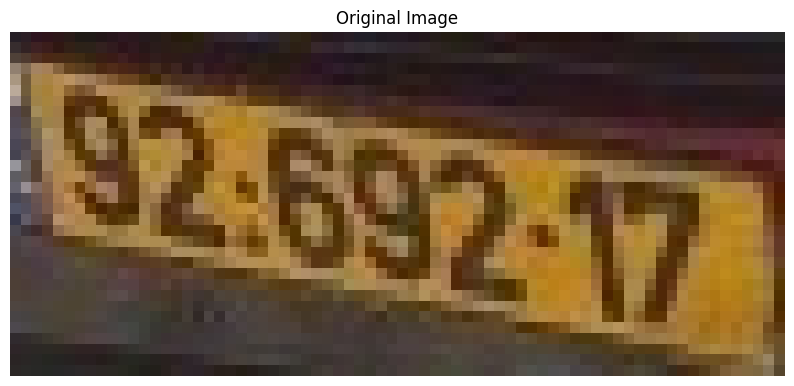

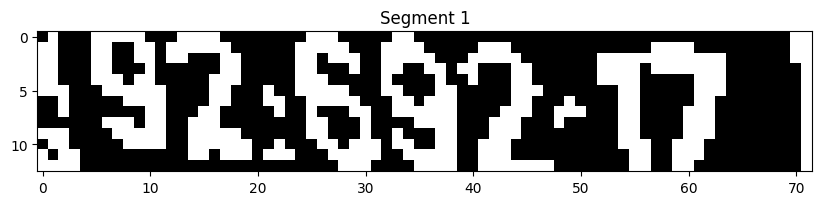

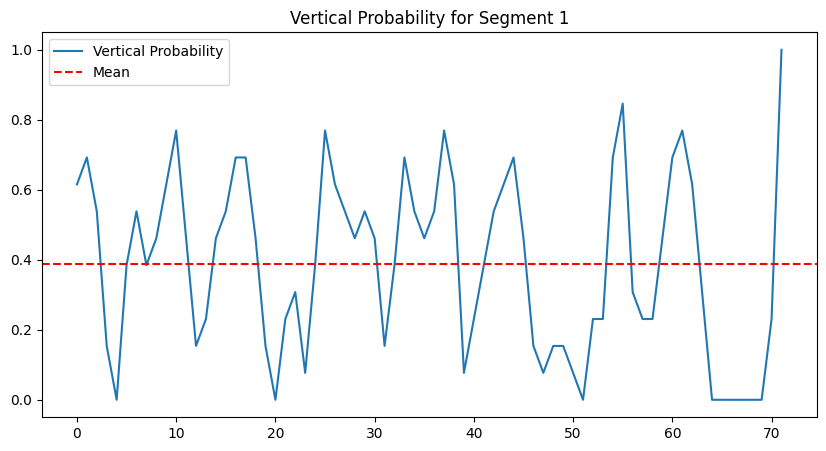

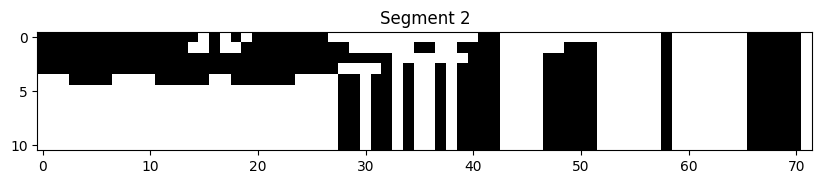

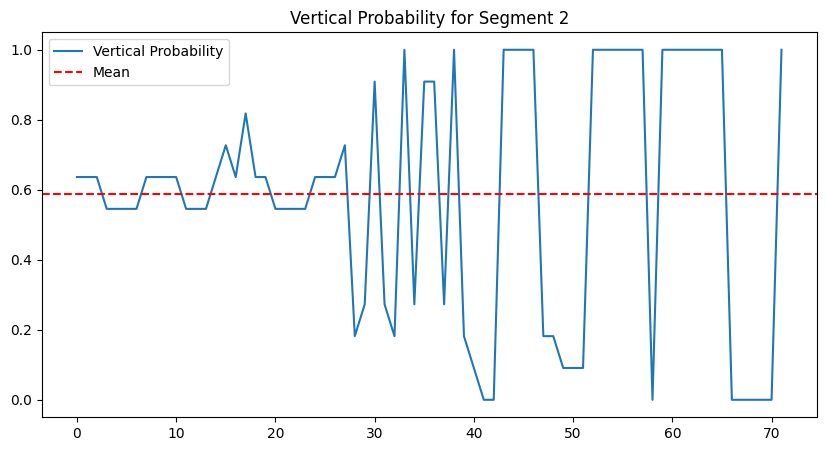

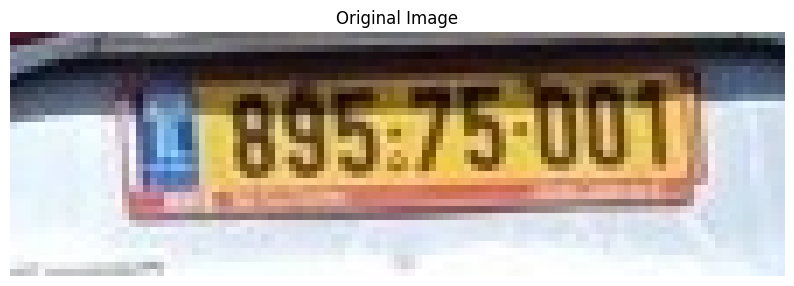

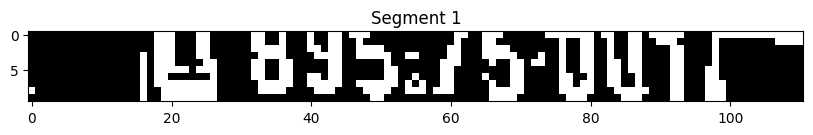

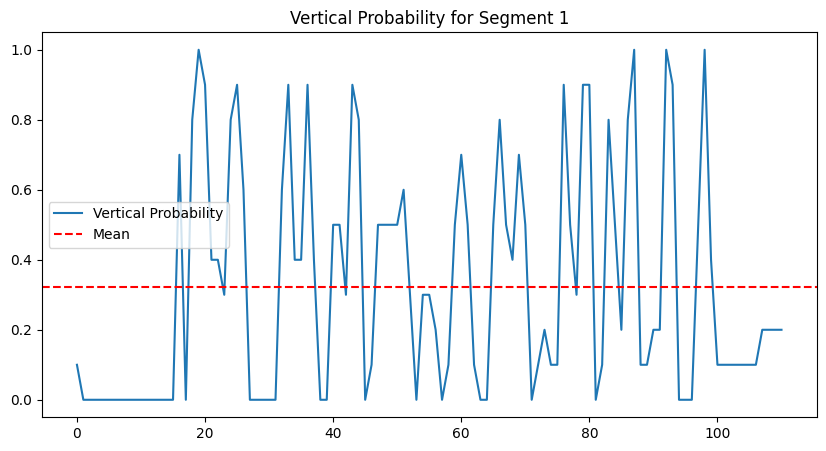

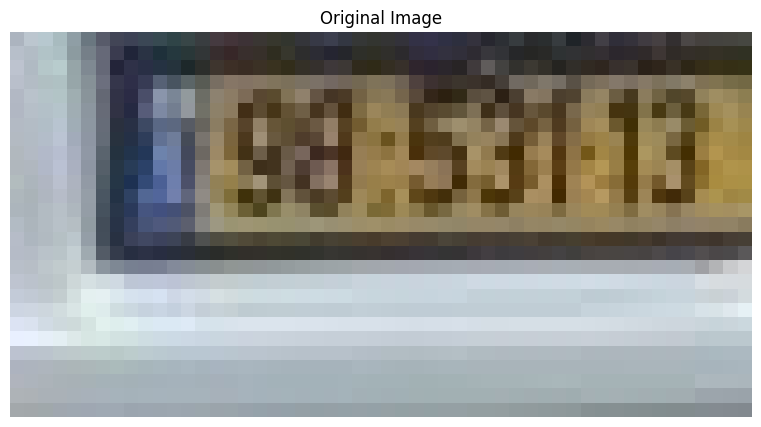

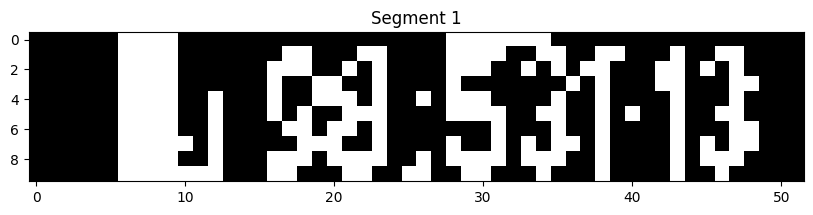

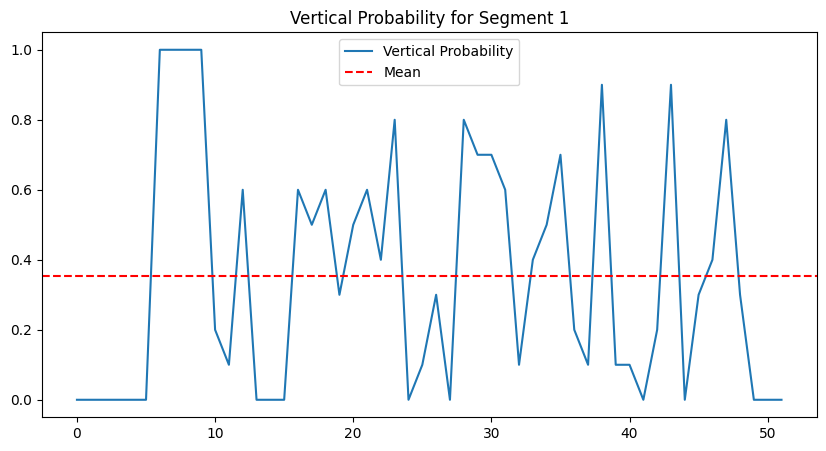

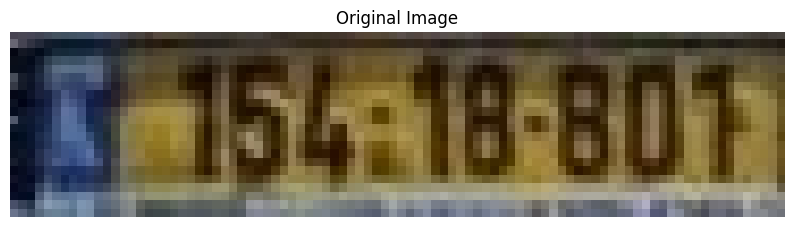

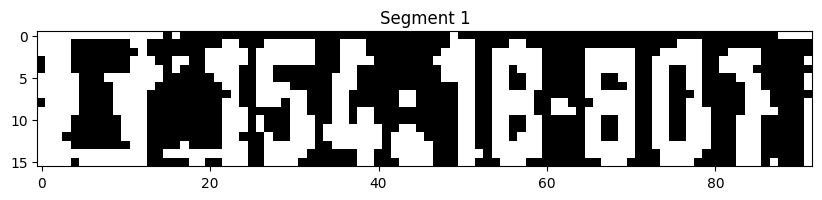

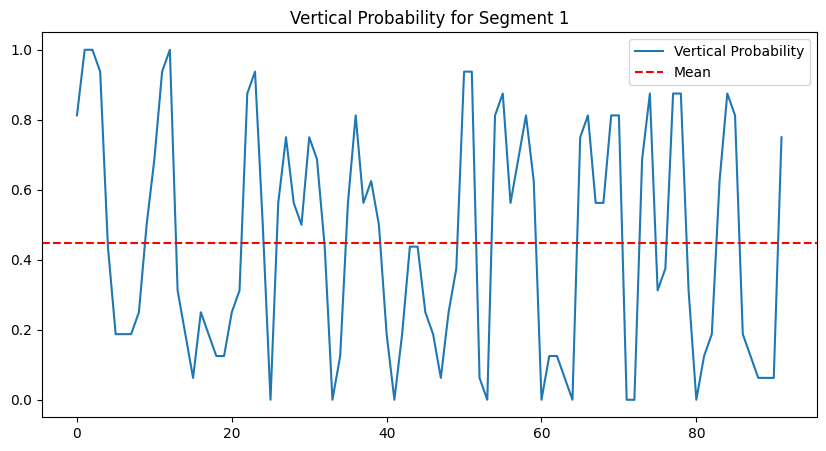

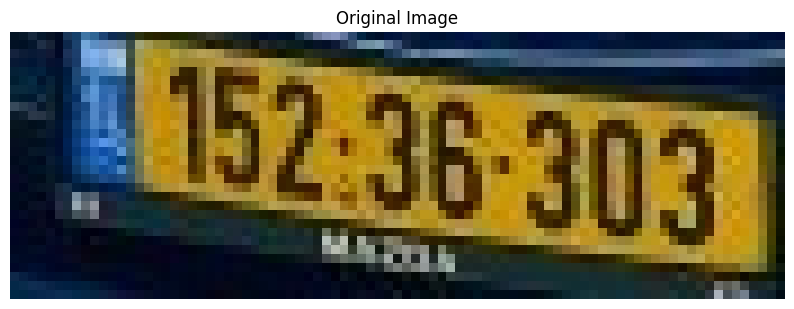

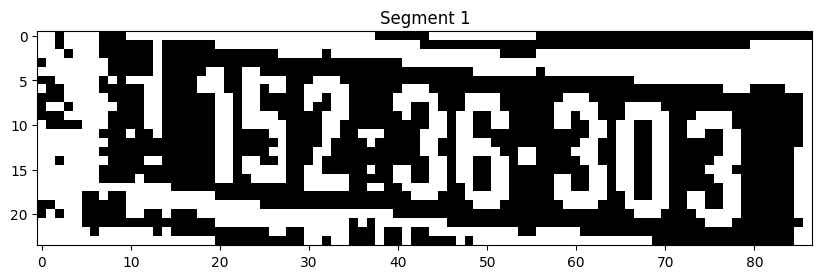

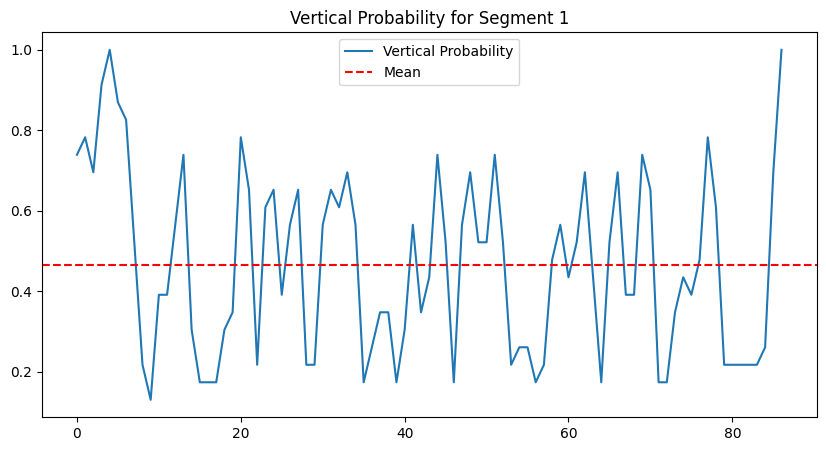

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=21, C=3):
    image = cv2.imread(image_path)
    _, green_channel, _ = cv2.split(image)
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    adaptive_thresholded = cv2.adaptiveThreshold(
        green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return image, adaptive_thresholded, green_corrected

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to apply vertical shear
def apply_vertical_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, 0, 0], [shear_factor, 1, -shear_factor * width / 2]], dtype=np.float32)
    new_height = int(height + abs(shear_factor * width))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (width, new_height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to calculate the horizontal "1" to "0" ratio
def calculate_horizontal_ratio(image, middle_start_ratio=0.25, middle_end_ratio=0.75):
    height, width = image.shape
    middle_start = int(width * middle_start_ratio)
    middle_end = int(width * middle_end_ratio)
    horizontal_sum = np.sum(image[:, middle_start:middle_end], axis=1)
    horizontal_prob = horizontal_sum / np.max(horizontal_sum)
    return horizontal_prob

# Function to calculate the vertical "1" to "0" ratio
def calculate_vertical_ratio(image):
    vertical_sum = np.sum(image, axis=0)
    vertical_prob = vertical_sum / np.max(vertical_sum)
    return vertical_prob

# Function to find consistent segments in the horizontal probability
def find_consistent_segments(horizontal_prob, min_ratio=0.15, max_ratio=0.75, delta=0.2, min_length_ratio=0.20):
    total_length = len(horizontal_prob)
    if(max_ratio>0.85):max_ratio=0.85
    if(min_ratio<0.15):min_ratio=0.15
    min_length = int(total_length * min_length_ratio)
    
    segments = []
    start = None
    temp_avg= 0
    total_avg=0
    count = 0
    for i in range(total_length):
        if horizontal_prob[i] < min_ratio and start is None and (i<total_length-1):
            start = i
            if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                total_avg=horizontal_prob[i+1]
                temp_avg=horizontal_prob[i+1]
                count =1
                                
        elif min_ratio <= horizontal_prob[i] <= max_ratio:
            if start is not None:
                if abs(horizontal_prob[i] - total_avg) > delta:
                    if (i - start) >= min_length:
                        segments.append((start, i))
                        start = None
                        count =0
                    else: 
                        total_avg=horizontal_prob[i]
                        temp_avg=horizontal_prob[i]
                        start = i
                        count =1
                else:
                    temp_avg+=horizontal_prob[i]
                    count+=1
                    total_avg=temp_avg/count
            elif(i != start):
                total_avg=horizontal_prob[i]
                temp_avg=horizontal_prob[i]
                start = i
                count =1
        else:
            if start is not None and (i - start) >= min_length:
                if horizontal_prob[i] < max_ratio:
                    segments.append((start, i))
                    start = None
                elif (i - 1 - start) >= min_length:
                    segments.append((start, i - 1))
                    start = None
            else: 
                if(horizontal_prob[i]<min_ratio and (i<total_length-1)): 
                    start = i
                    if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                        total_avg=horizontal_prob[i+1]
                        temp_avg=horizontal_prob[i+1]
                        count =1
                else: start = None

    if start is not None and (total_length - start) >= min_length:
        segments.append((start, total_length - 1))

    return segments

def segment_image_from_original(image_path):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path)
    
    # Detect horizontal lines
    height_adp, width_adp = adaptive_thresholded.shape
    horizontal_lines = cv2.HoughLinesP(adaptive_thresholded, rho=1, theta=np.pi / 180, threshold=30, minLineLength=int(width_adp * 0.5), maxLineGap=2)
    horizontal_angles = []
    if horizontal_lines is not None:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            if abs(angle) < 45: # Consider angles close to horizontal
                horizontal_angles.append(angle)
        horizontal_angle = np.median(horizontal_angles) if horizontal_angles else 0
    else:
        horizontal_angle = 0
    
    # Apply vertical shear based on horizontal angle
    sheared_image = apply_vertical_shear(adaptive_thresholded, -horizontal_angle, is_binary=True)
    
    # Calculate horizontal probability
    horizontal_prob = calculate_horizontal_ratio(sheared_image)
    segments = find_consistent_segments(horizontal_prob, delta=np.mean(horizontal_prob),min_ratio=np.mean(horizontal_prob)*0.20, max_ratio=np.mean(horizontal_prob)*2)
    
    final_segments = []
    for start, end in segments:
        segment_image = sheared_image[start:end, :]
        final_segments.append(segment_image)
    
    return original_image, final_segments

# Example usage
folder_path = 'clips_LP'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, 5)

for image_path in random_images:
    original_image, segments = segment_image_from_original(image_path)
    
    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # Display each segment and its vertical probability chart
    for j, segment in enumerate(segments):
        plt.figure(figsize=(10, 5))
        plt.imshow(segment, cmap='gray')
        plt.title(f'Segment {j+1}')
        plt.axis('on')
        plt.show()
        
        # Calculate vertical probability
        vertical_prob = calculate_vertical_ratio(segment)
        vertical_mean = np.mean(vertical_prob)
        
        # Plot vertical probability chart
        plt.figure(figsize=(10, 5))
        plt.plot(vertical_prob, label='Vertical Probability')
        plt.axhline(y=vertical_mean, color='r', linestyle='--', label='Mean')
        plt.title(f'Vertical Probability for Segment {j+1}')
        plt.legend()
        plt.show()


v segment


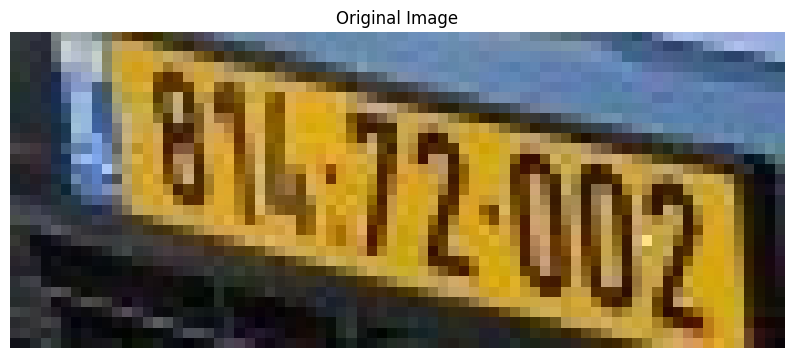

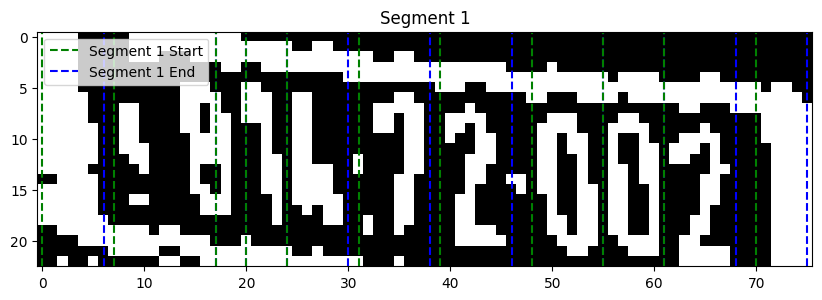

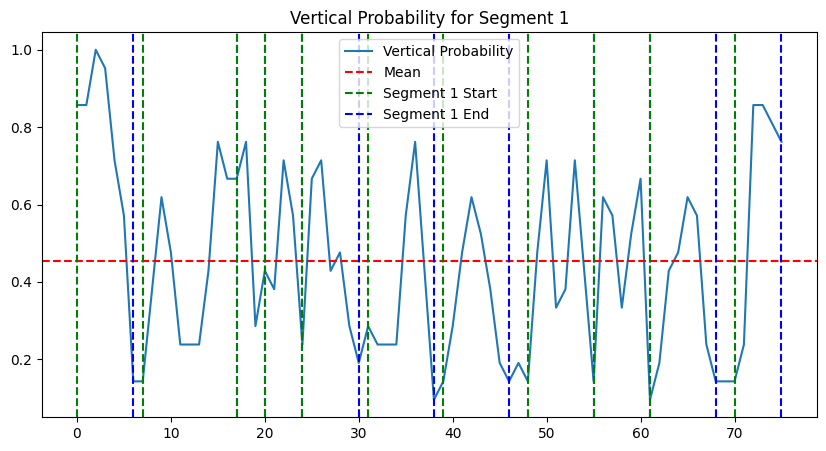

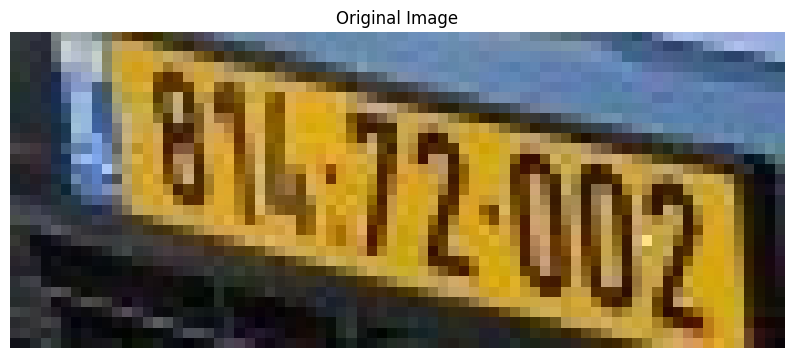

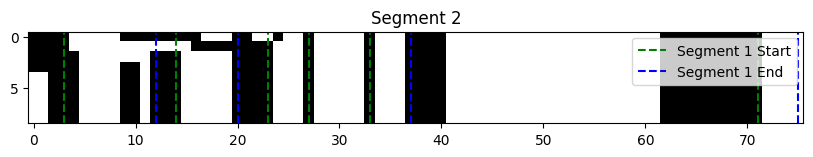

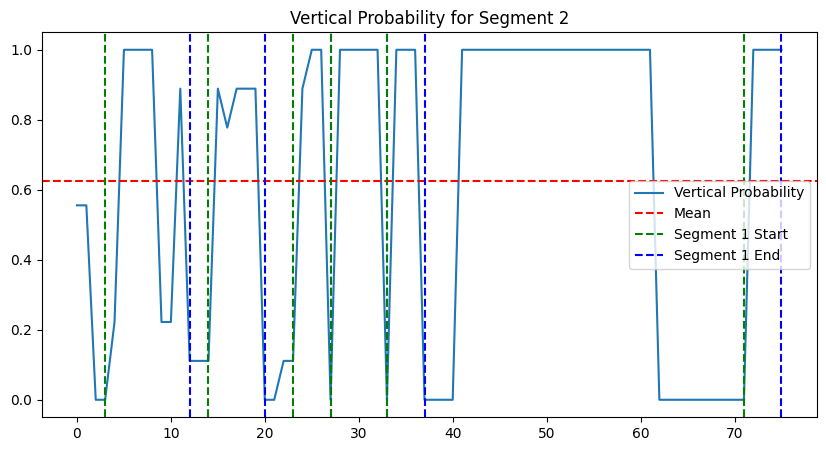

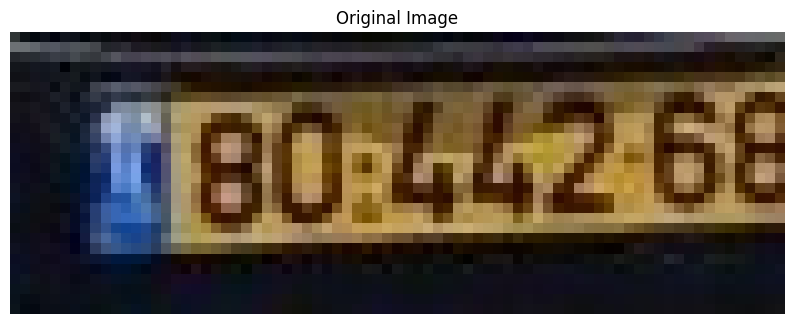

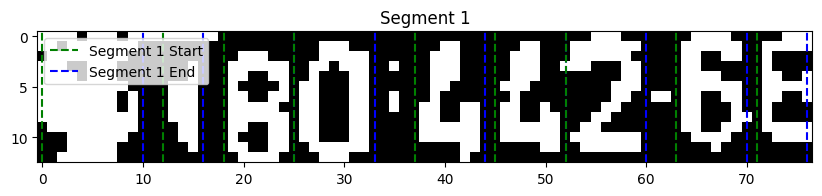

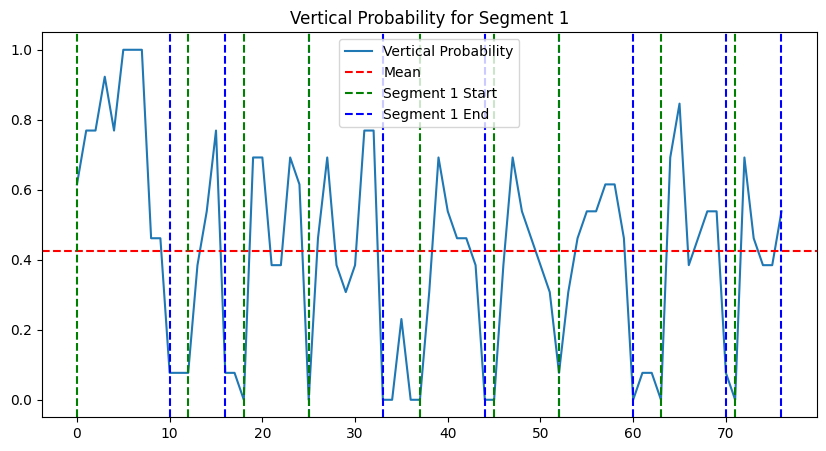

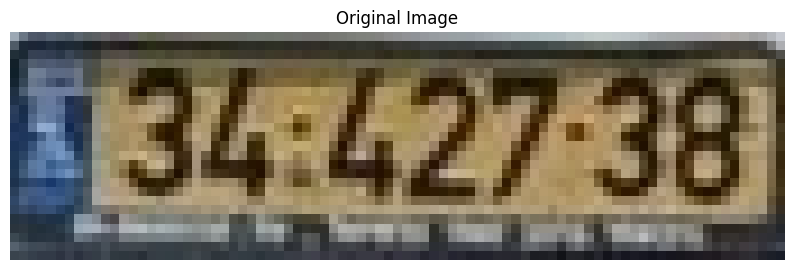

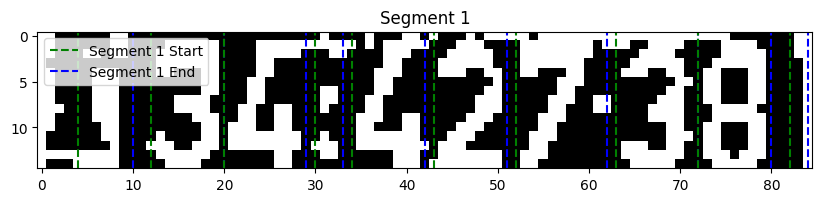

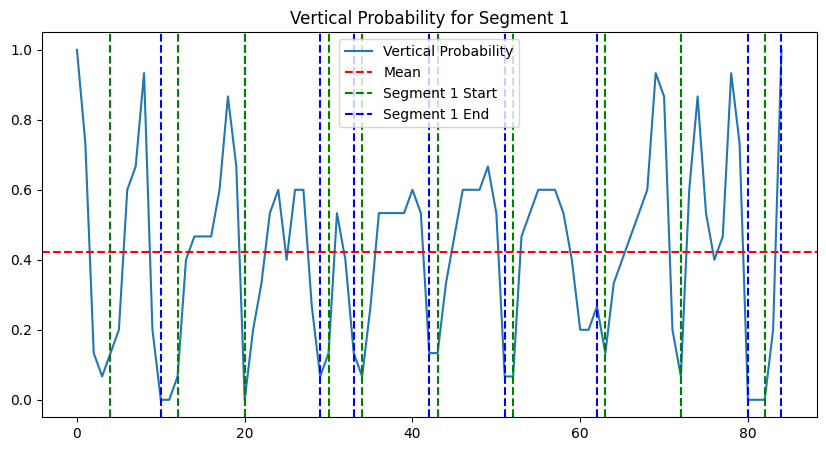

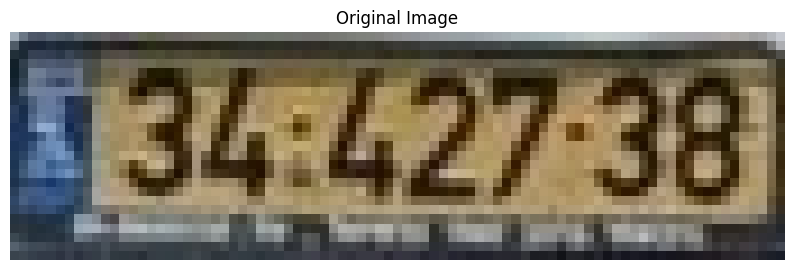

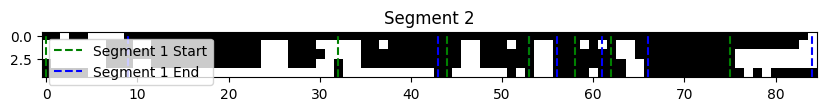

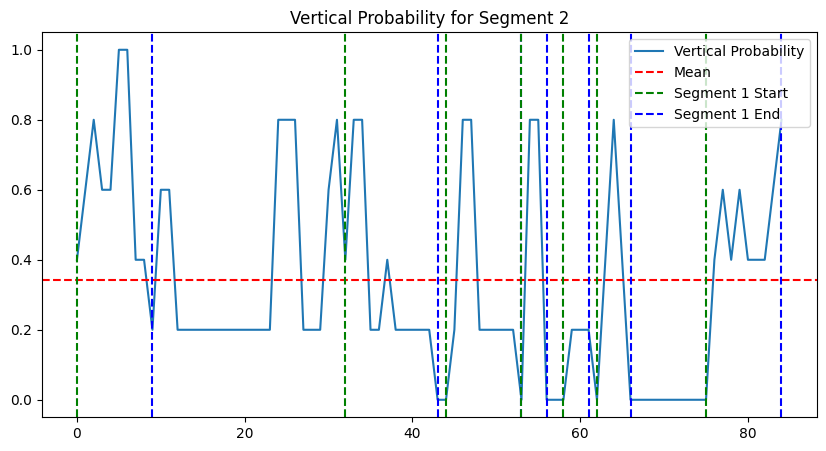

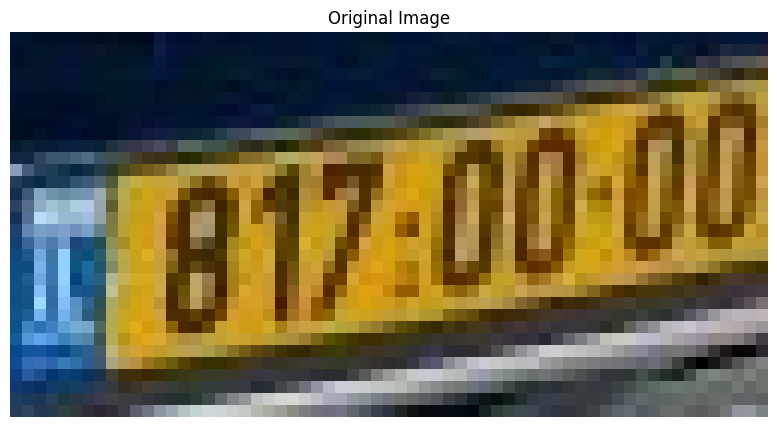

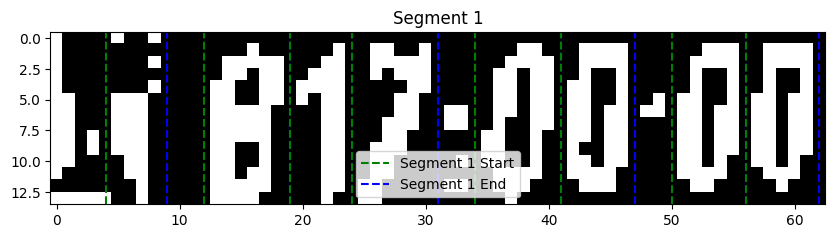

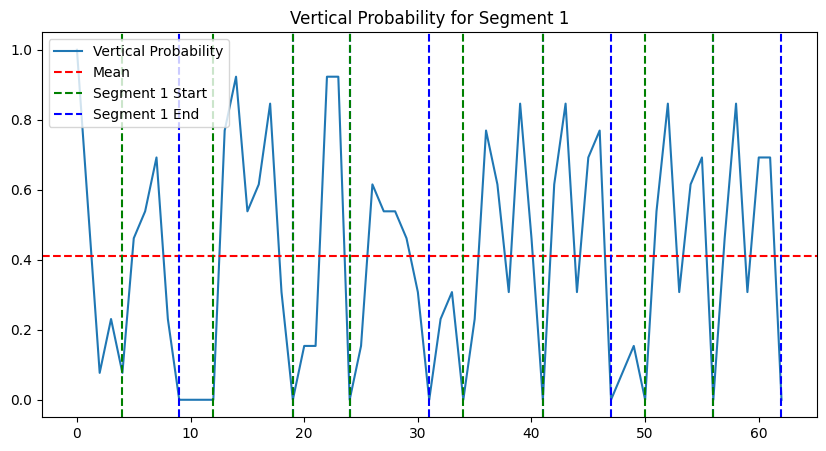

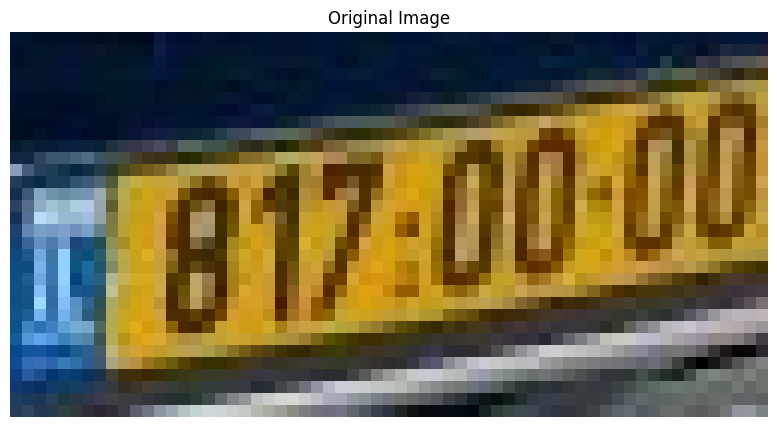

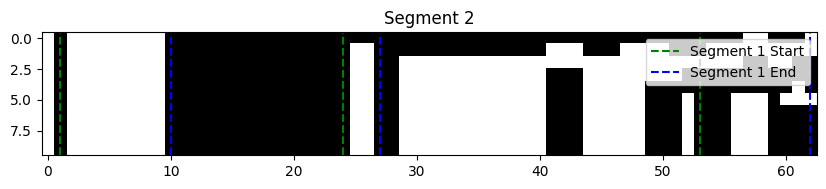

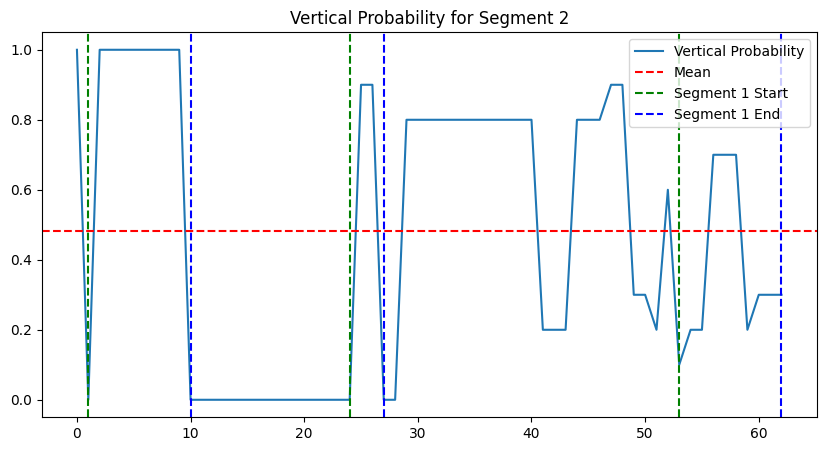

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math
from scipy.signal import find_peaks  # Import find_peaks from scipy.signal

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=21, C=3):
    image = cv2.imread(image_path)
    _, green_channel, _ = cv2.split(image)
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    adaptive_thresholded = cv2.adaptiveThreshold(
        green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return image, adaptive_thresholded, green_corrected

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to apply vertical shear
def apply_vertical_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, 0, 0], [shear_factor, 1, -shear_factor * width / 2]], dtype=np.float32)
    new_height = int(height + abs(shear_factor * width))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (width, new_height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to calculate the horizontal "1" to "0" ratio
def calculate_horizontal_ratio(image, middle_start_ratio=0.25, middle_end_ratio=0.75):
    height, width = image.shape
    middle_start = int(width * middle_start_ratio)
    middle_end = int(width * middle_end_ratio)
    horizontal_sum = np.sum(image[:, middle_start:middle_end], axis=1)
    horizontal_prob = horizontal_sum / np.max(horizontal_sum)
    return horizontal_prob

# Function to calculate the vertical "1" to "0" ratio
def calculate_vertical_ratio(image):
    vertical_sum = np.sum(image, axis=0)
    vertical_prob = vertical_sum / np.max(vertical_sum)
    return vertical_prob

# Function to find consistent segments in the horizontal probability
def find_consistent_segments(horizontal_prob, min_ratio=0.15, max_ratio=0.75, delta=0.2, min_length_ratio=0.20):
    total_length = len(horizontal_prob)
    if(max_ratio>0.85):max_ratio=0.85
    if(min_ratio<0.15):min_ratio=0.15
    min_length = int(total_length * min_length_ratio)
    
    segments = []
    start = None
    temp_avg= 0
    total_avg=0
    count = 0
    for i in range(total_length):
        if horizontal_prob[i] < min_ratio and start is None and (i<total_length-1):
            start = i
            if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                total_avg=horizontal_prob[i+1]
                temp_avg=horizontal_prob[i+1]
                count =1
                                
        elif min_ratio <= horizontal_prob[i] <= max_ratio:
            if start is not None:
                if abs(horizontal_prob[i] - total_avg) > delta:
                    if (i - start) >= min_length:
                        segments.append((start, i))
                        start = None
                        count =0
                    else: 
                        total_avg=horizontal_prob[i]
                        temp_avg=horizontal_prob[i]
                        start = i
                        count =1
                else:
                    temp_avg+=horizontal_prob[i]
                    count+=1
                    total_avg=temp_avg/count
            elif(i != start):
                total_avg=horizontal_prob[i]
                temp_avg=horizontal_prob[i]
                start = i
                count =1
        else:
            if start is not None and (i - start) >= min_length:
                if horizontal_prob[i] < max_ratio:
                    segments.append((start, i))
                    start = None
                elif (i - 1 - start) >= min_length:
                    segments.append((start, i - 1))
                    start = None
            else: 
                if(horizontal_prob[i]<min_ratio and (i<total_length-1)): 
                    start = i
                    if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                        total_avg=horizontal_prob[i+1]
                        temp_avg=horizontal_prob[i+1]
                        count =1
                else: start = None

    if start is not None and (total_length - start) >= min_length:
        segments.append((start, total_length - 1))

    return segments

def segment_image_from_original(image_path):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path)
    
    # Detect horizontal lines
    height_adp, width_adp = adaptive_thresholded.shape
    horizontal_lines = cv2.HoughLinesP(adaptive_thresholded, rho=1, theta=np.pi / 180, threshold=30, minLineLength=int(width_adp * 0.5), maxLineGap=2)
    horizontal_angles = []
    if horizontal_lines is not None:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            if abs(angle) < 45: # Consider angles close to horizontal
                horizontal_angles.append(angle)
        horizontal_angle = np.median(horizontal_angles) if horizontal_angles else 0
    else:
        horizontal_angle = 0
    
    # Apply vertical shear based on horizontal angle
    sheared_image = apply_vertical_shear(adaptive_thresholded, -horizontal_angle, is_binary=True)
    
    # Calculate horizontal probability
    horizontal_prob = calculate_horizontal_ratio(sheared_image)
    segments = find_consistent_segments(horizontal_prob, delta=np.mean(horizontal_prob),min_ratio=np.mean(horizontal_prob)*0.20, max_ratio=np.mean(horizontal_prob)*2)
    
    final_segments = []
    for start, end in segments:
        segment_image = sheared_image[start:end, :]
        final_segments.append(segment_image)
    
    return original_image, final_segments

def segment_vertical(vertical_prob, min_ratio=0.1, min_length_ratio=0.05,max_length_ratio=0.2 ,mean=0.5):
    total_length = len(vertical_prob)
    #if(min_ratio<0.15):min_ratio=0.15
    delta=0.15
    min_ratio=0.15
    min_length = 3
    max_length = int(total_length * max_length_ratio)
    
    
    segments = []
    start = None
    peak_count_min = 0
    max_value=0
    peak_count_max =0
    l = 0
    m = 0
    r = 0
    for i in range(total_length):
        if(start is None):
            start=i
            l=vertical_prob[i]
        else:
            m=vertical_prob[i]
            if(i != start):
                if(i<total_length-1):
                    r=vertical_prob[i+1]
                    if(l>m and r>m and max_value!=m):
                        max_value = m
                        peak_count_min+=1
                        if(m<mean*0.35):
                            if(max_length>=(i - start) >= min_length ):
                                segments.append((start, i))
                            peak_count_min = 0
                            peak_count_max = 0
                            max_value=0
                            start=i
                    if(l<m and r<m):
                        peak_count_max +=1
                        if(m<mean):
                            if(max_length>=(i - start) >= min_length ):
                                segments.append((start, i))
                            peak_count_min = 0
                            max_value=0
                            peak_count_max = 0
                            start=i
                        
            if(vertical_prob[i]<min_ratio or peak_count_min>1):
                if(max_length>=(i - start) >= min_length ):
                    segments.append((start, i))
                peak_count_min = 0
                peak_count_max = 0
                max_value=0
                start=i
            
                
            if(r!=m):l=vertical_prob[i]
            
                
    if start is not None and max_length>=(total_length - start) >= min_length:
        segments.append((start, total_length - 1))
            
    return segments

# Example usage
folder_path = 'clips_LP'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, 5)

for image_path in random_images:
    original_image, segments = segment_image_from_original(image_path)
    
    for j, segment in enumerate(segments):
        vertical_prob = calculate_vertical_ratio(segment)
        vertical_mean = np.mean(vertical_prob)
        
        vertical_segments = segment_vertical(vertical_prob, mean=vertical_mean)
        
        # Display the original image
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.show()
        
        # Display the segmented image with vertical segment lines
        plt.figure(figsize=(10, 5))
        plt.imshow(segment, cmap='gray')
        for k, (start, end) in enumerate(vertical_segments):
            plt.axvline(x=start, color='g', linestyle='--', label=f'Segment {k+1} Start' if k == 0 else "")
            plt.axvline(x=end, color='b', linestyle='--', label=f'Segment {k+1} End' if k == 0 else "")
        plt.title(f'Segment {j+1}')
        plt.axis('on')
        plt.legend()
        plt.show()
        
        # Display the vertical probability chart with segment lines
        plt.figure(figsize=(10, 5))
        plt.plot(vertical_prob, label='Vertical Probability')
        plt.axhline(y=vertical_mean, color='r', linestyle='--', label='Mean')
        for k, (start, end) in enumerate(vertical_segments):
            plt.axvline(x=start, color='g', linestyle='--', label=f'Segment {k+1} Start' if k == 0 else "")
            plt.axvline(x=end, color='b', linestyle='--', label=f'Segment {k+1} End' if k == 0 else "")
        plt.title(f'Vertical Probability for Segment {j+1}')
        plt.legend()
        plt.show()



In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math
from scipy.signal import find_peaks  # Import find_peaks from scipy.signal

# Function to apply gamma correction
def adjust_gamma(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function to process an image
def process_image(image_path, block_size=21, C=3):
    image = cv2.imread(image_path)
    _, green_channel, _ = cv2.split(image)
    green_corrected = adjust_gamma(green_channel, gamma=1.2)
    adaptive_thresholded = cv2.adaptiveThreshold(
        green_corrected, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return image, adaptive_thresholded, green_corrected

# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to apply vertical shear
def apply_vertical_shear(image, angle, is_binary=False):
    angle_rad = np.radians(angle)
    shear_factor = np.tan(angle_rad)
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, 0, 0], [shear_factor, 1, -shear_factor * width / 2]], dtype=np.float32)
    new_height = int(height + abs(shear_factor * width))
    sheared_image = cv2.warpAffine(
        image, shear_matrix, (width, new_height), flags=cv2.INTER_NEAREST if is_binary else cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return sheared_image

# Function to calculate the horizontal "1" to "0" ratio
def calculate_horizontal_ratio(image, middle_start_ratio=0.25, middle_end_ratio=0.75):
    height, width = image.shape
    middle_start = int(width * middle_start_ratio)
    middle_end = int(width * middle_end_ratio)
    horizontal_sum = np.sum(image[:, middle_start:middle_end], axis=1)
    horizontal_prob = horizontal_sum / np.max(horizontal_sum)
    return horizontal_prob

# Function to calculate the vertical "1" to "0" ratio
def calculate_vertical_ratio(image):
    vertical_sum = np.sum(image, axis=0)
    vertical_prob = vertical_sum / np.max(vertical_sum)
    return vertical_prob

# Function to find consistent segments in the horizontal probability
def find_consistent_segments(horizontal_prob, min_ratio=0.15, max_ratio=0.75, delta=0.2, min_length_ratio=0.20):
    total_length = len(horizontal_prob)
    if(max_ratio>0.85):max_ratio=0.85
    if(min_ratio<0.15):min_ratio=0.15
    min_length = int(total_length * min_length_ratio)
    
    segments = []
    start = None
    temp_avg= 0
    total_avg=0
    count = 0
    for i in range(total_length):
        if horizontal_prob[i] < min_ratio and start is None and (i<total_length-1):
            start = i
            if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                total_avg=horizontal_prob[i+1]
                temp_avg=horizontal_prob[i+1]
                count =1
                                
        elif min_ratio <= horizontal_prob[i] <= max_ratio:
            if start is not None:
                if abs(horizontal_prob[i] - total_avg) > delta:
                    if (i - start) >= min_length:
                        segments.append((start, i))
                        start = None
                        count =0
                    else: 
                        total_avg=horizontal_prob[i]
                        temp_avg=horizontal_prob[i]
                        start = i
                        count =1
                else:
                    temp_avg+=horizontal_prob[i]
                    count+=1
                    total_avg=temp_avg/count
            elif(i != start):
                total_avg=horizontal_prob[i]
                temp_avg=horizontal_prob[i]
                start = i
                count =1
        else:
            if start is not None and (i - start) >= min_length:
                if horizontal_prob[i] < max_ratio:
                    segments.append((start, i))
                    start = None
                elif (i - 1 - start) >= min_length:
                    segments.append((start, i - 1))
                    start = None
            else: 
                if(horizontal_prob[i]<min_ratio and (i<total_length-1)): 
                    start = i
                    if(min_ratio<=horizontal_prob[i+1]<=max_ratio):
                        total_avg=horizontal_prob[i+1]
                        temp_avg=horizontal_prob[i+1]
                        count =1
                else: start = None

    if start is not None and (total_length - start) >= min_length:
        segments.append((start, total_length - 1))

    return segments

def segment_image_from_original(image_path):
    original_image, adaptive_thresholded, green_corrected = process_image(image_path)
    
    # Detect horizontal lines
    height_adp, width_adp = adaptive_thresholded.shape
    horizontal_lines = cv2.HoughLinesP(adaptive_thresholded, rho=1, theta=np.pi / 180, threshold=30, minLineLength=int(width_adp * 0.5), maxLineGap=2)
    horizontal_angles = []
    if horizontal_lines is not None:
        for line in horizontal_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)
            if abs(angle) < 45: # Consider angles close to horizontal
                horizontal_angles.append(angle)
        horizontal_angle = np.median(horizontal_angles) if horizontal_angles else 0
    else:
        horizontal_angle = 0
    
    # Apply vertical shear based on horizontal angle
    sheared_image = apply_vertical_shear(adaptive_thresholded, -horizontal_angle, is_binary=True)
    
    # Calculate horizontal probability
    horizontal_prob = calculate_horizontal_ratio(sheared_image)
    segments = find_consistent_segments(horizontal_prob, delta=np.mean(horizontal_prob),min_ratio=np.mean(horizontal_prob)*0.20, max_ratio=np.mean(horizontal_prob)*2)
    
    final_segments = []
    for start, end in segments:
        segment_image = sheared_image[start:end, :]
        final_segments.append(segment_image)
    
    return original_image, final_segments

def segment_vertical(vertical_prob, min_ratio=0.1, min_length_ratio=0.05,max_length_ratio=0.2 ,mean=0.5):
    total_length = len(vertical_prob)
    #if(min_ratio<0.15):min_ratio=0.15
    delta=0.15
    min_ratio=0.15
    min_length = 3
    max_length = int(total_length * max_length_ratio)
    
    
    segments = []
    start = None
    peak_count_min = 0
    max_value=0
    peak_count_max =0
    l = 0
    m = 0
    r = 0
    for i in range(total_length):
        if(start is None):
            start=i
            l=vertical_prob[i]
        else:
            m=vertical_prob[i]
            if(i != start):
                if(i<total_length-1):
                    r=vertical_prob[i+1]
                    if(l>m and r>m and max_value!=m):
                        max_value = m
                        peak_count_min+=1
                        if(m<mean*0.35):
                            if(max_length>=(i - start) >= min_length ):
                                segments.append((start, i))
                            peak_count_min = 0
                            peak_count_max = 0
                            max_value=0
                            start=i
                    if(l<m and r<m):
                        peak_count_max +=1
                        if(m<mean):
                            if(max_length>=(i - start) >= min_length ):
                                segments.append((start, i))
                            peak_count_min = 0
                            max_value=0
                            peak_count_max = 0
                            start=i
                        
            if(vertical_prob[i]<min_ratio or peak_count_min>1):
                if(max_length>=(i - start) >= min_length ):
                    segments.append((start, i))
                peak_count_min = 0
                peak_count_max = 0
                max_value=0
                start=i
            
                
            if(r!=m):l=vertical_prob[i]
            
                
    if start is not None and max_length>=(total_length - start) >= min_length:
        segments.append((start, total_length - 1))
            
    return segments

# Example usage
folder_path = 'clips_LP'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, 5)

for image_path in random_images:
    original_image, segments = segment_image_from_original(image_path)
    
    for j, segment in enumerate(segments):
        vertical_prob = calculate_vertical_ratio(segment)
        vertical_mean = np.mean(vertical_prob)
        
        vertical_segments = segment_vertical(vertical_prob, mean=vertical_mean)
        
        # Display the original image
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.show()
        
        # Display the segmented image with vertical segment lines
        plt.figure(figsize=(10, 5))
        plt.imshow(segment, cmap='gray')
        for k, (start, end) in enumerate(vertical_segments):
            plt.axvline(x=start, color='g', linestyle='--', label=f'Segment {k+1} Start' if k == 0 else "")
            plt.axvline(x=end, color='b', linestyle='--', label=f'Segment {k+1} End' if k == 0 else "")
        plt.title(f'Segment {j+1}')
        plt.axis('on')
        plt.legend()
        plt.show()
        
        # Display the vertical probability chart with segment lines
        plt.figure(figsize=(10, 5))
        plt.plot(vertical_prob, label='Vertical Probability')
        plt.axhline(y=vertical_mean, color='r', linestyle='--', label='Mean')
        for k, (start, end) in enumerate(vertical_segments):
            plt.axvline(x=start, color='g', linestyle='--', label=f'Segment {k+1} Start' if k == 0 else "")
            plt.axvline(x=end, color='b', linestyle='--', label=f'Segment {k+1} End' if k == 0 else "")
        plt.title(f'Vertical Probability for Segment {j+1}')
        plt.legend()
        plt.show()



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()